In [47]:
# 基本ライブラリ
import pandas as pd
import pandas.io.sql as psql
import numpy as np
import numpy.random as rd
import gc
import multiprocessing as mp
import os
import sys
import pickle
from collections import defaultdict
from glob import glob
import math
from datetime import datetime as dt
from pathlib import Path
import scipy.stats as st
import re
import shutil
from tqdm import tqdm_notebook as tqdm
import datetime
ts_conv = np.vectorize(datetime.datetime.fromtimestamp) # 秒ut(10桁) ⇒ 日付

# グラフ描画系
import matplotlib
from matplotlib import font_manager
import matplotlib.pyplot as plt
import matplotlib.cm as cm
from matplotlib import rc

from matplotlib import animation as ani
from IPython.display import Image

plt.rcParams["patch.force_edgecolor"] = True
#rc('text', usetex=True)
from IPython.display import display # Allows the use of display() for DataFrames
import seaborn as sns
sns.set(style="whitegrid", palette="muted", color_codes=True)
sns.set_style("whitegrid", {'grid.linestyle': '--'})
red = sns.xkcd_rgb["light red"]
green = sns.xkcd_rgb["medium green"]
blue = sns.xkcd_rgb["denim blue"]

#カラム内の文字数。デフォルトは50
pd.set_option("display.max_colwidth", 100)

#行数
pd.set_option("display.max_rows", None)
pd.set_option("display.max_columns", None)
#
pd.options.display.float_format = '{:,.5f}'.format

%matplotlib inline

In [2]:

from sklearn.preprocessing import StandardScaler
from sklearn.metrics import mean_absolute_error

from sklearn.preprocessing import LabelEncoder
from sklearn.model_selection import StratifiedKFold, KFold, RepeatedKFold

from sklearn import metrics
import json

import warnings
warnings.filterwarnings("ignore")


sys.path.append('..')
from lib.line_notif import send_message
#from lib.utils import matrics_rotate
from lib.utils import reduce_mem_usage, current_time, unpickle, to_pickle
from lib.utils import one_hot_encoder, apply_agg, multi_combine_categorical_feature
from lib.utils import import_data, get_split_indexer 

In [3]:


def group_mean_log_mae(y_true, y_pred, types, floor=1e-9):
    """
    Fast metric computation for this competition: https://www.kaggle.com/c/champs-scalar-coupling
    Code is from this kernel: https://www.kaggle.com/uberkinder/efficient-metric
    """
    maes = (y_true - y_pred).abs().groupby(types).mean()
    return np.log(maes.map(lambda x: max(x, floor))).mean()

In [4]:
train = pd.read_csv('../input/train.csv')
test = pd.read_csv('../input/test.csv')
structures = pd.read_csv('../input/structures.csv')

In [5]:
test.head()

,id,molecule_name,atom_index_0,atom_index_1,type
0,4658147,dsgdb9nsd_000004,2,0,2JHC
1,4658148,dsgdb9nsd_000004,2,1,1JHC
2,4658149,dsgdb9nsd_000004,2,3,3JHH
3,4658150,dsgdb9nsd_000004,3,0,1JHC
4,4658151,dsgdb9nsd_000004,3,1,2JHC


In [6]:
test_id = test.id.values

In [7]:
ls -l ../submit/v003_101/

total 4373032
-rw-r--r--  1 kenichi.matsui  1522739515  67162536  8 25 07:16 blending_v003_101_20seeds.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164368  8 25 07:08 submission_t_v003_101_100.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164914  8 25 07:09 submission_t_v003_101_101.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163061  8 25 07:08 submission_t_v003_101_102.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165057  8 25 07:10 submission_t_v003_101_103.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164273  8 25 07:12 submission_t_v003_101_104.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165088  8 25 07:11 submission_t_v003_101_105.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67165554  8 25 07:12 submission_t_v003_101_106.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67162665  8 25 07:14 submission_t_v003_101_107.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67163732  8 25 07:14 submission_t_v003_101_108.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67164816  8 25

In [13]:
# DATA_VERSION = "v003"
# TRIAL_NO = "101"

In [29]:
sub_files = [f"../submit/gcnn/004_5fold/submit_gcnn_fold{i}.csv" for i in range(5)]#np.sort(glob()).tolist()
# sub_files = np.sort(glob("../submit/v003_024/submission_t_v003_024_*.csv")).tolist() + \
#             np.sort(glob("../submit/v003_031/submission_t_v003_031_*.csv")).tolist() + \
#             np.sort(glob("../submit/v003_036/submission_t_v003_036_*.csv")).tolist()
#sub_files += ["../submit/v003_021/submission_t_v003_021.csv"]
len(sub_files)

5

In [30]:
sub_files

['../submit/gcnn/004_5fold/submit_gcnn_fold0.csv',
 '../submit/gcnn/004_5fold/submit_gcnn_fold1.csv',
 '../submit/gcnn/004_5fold/submit_gcnn_fold2.csv',
 '../submit/gcnn/004_5fold/submit_gcnn_fold3.csv',
 '../submit/gcnn/004_5fold/submit_gcnn_fold4.csv']

In [31]:
sub_list = [pd.read_csv(f, index_col=0).loc[test_id] for f in sub_files]

In [32]:
submit_list_df = pd.concat(sub_list, axis=1)
submit_list_df.columns = [Path(f).stem for f in sub_files]
#submit_list_df["mean_score"] = submit_list_df.mean(axis=1).values
submit_list_df["mean_score"] = submit_list_df.median(axis=1).values

In [33]:
submit_list_df.shape, test.shape

((2505542, 6), (2505542, 5))

In [34]:
submit_list_df.head()

,submit_gcnn_fold0,submit_gcnn_fold1,submit_gcnn_fold2,submit_gcnn_fold3,submit_gcnn_fold4,mean_score
id,,,,,,
4658147,9.12358,17.98458,5.87898,7.14027,12.86213,9.12358
4658148,137.26660,132.39792,160.72449,142.90717,148.01318,142.90717
4658149,-0.76031,3.11297,0.45421,2.30881,5.46108,2.30881
4658150,128.46310,155.77805,138.14603,131.82567,116.50828,131.82567
4658151,8.57869,16.52334,7.47442,6.94645,12.15413,8.57869


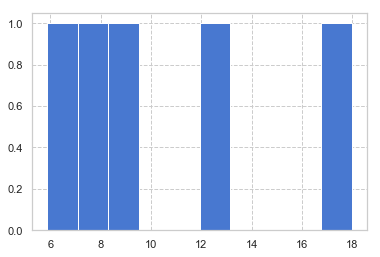

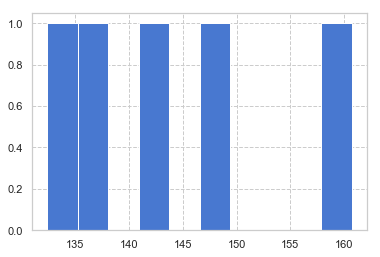

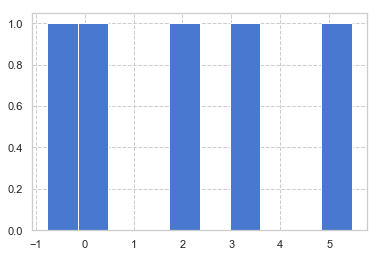

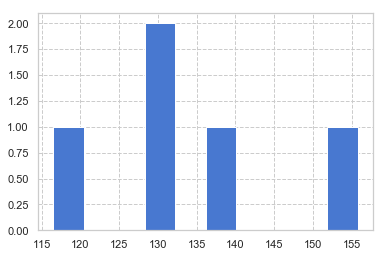

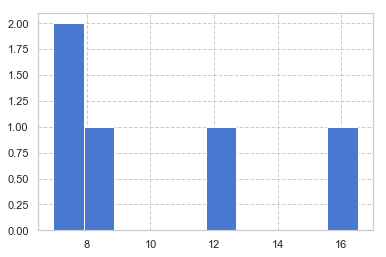

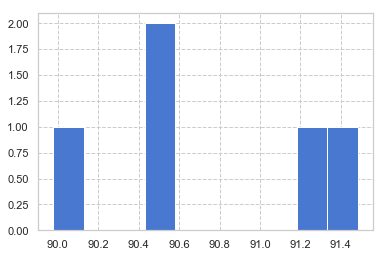

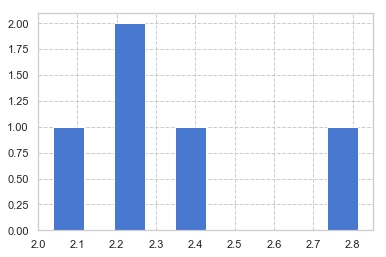

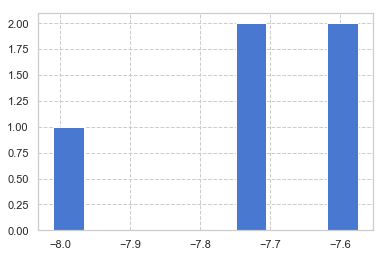

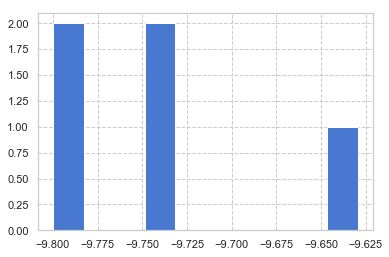

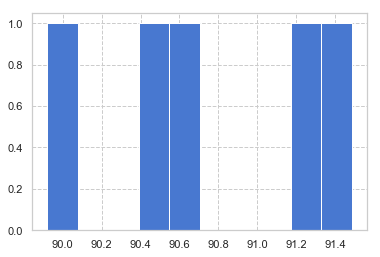

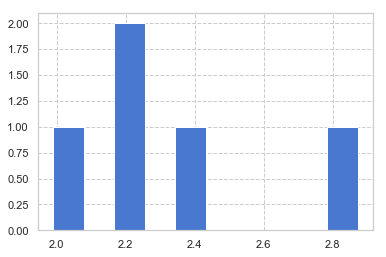

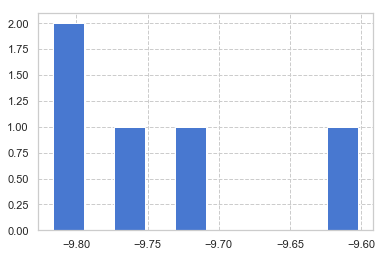

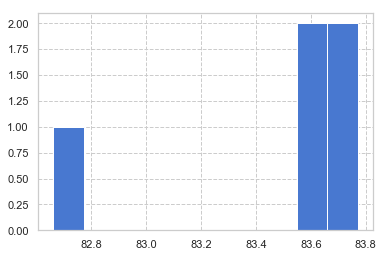

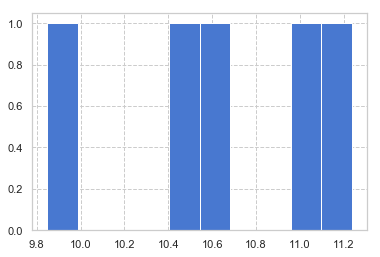

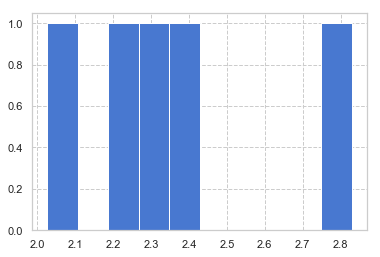

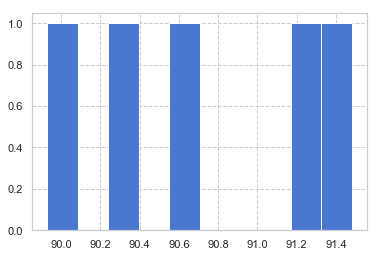

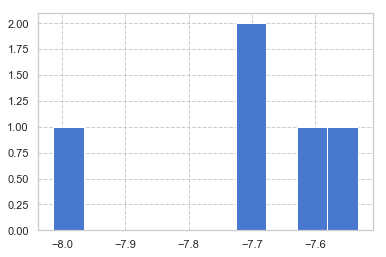

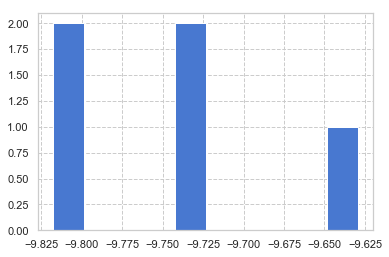

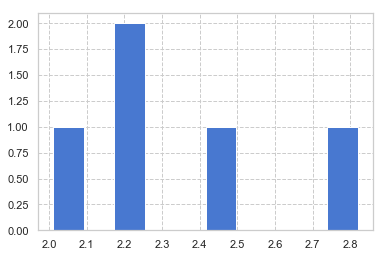

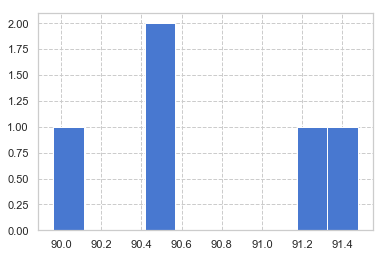

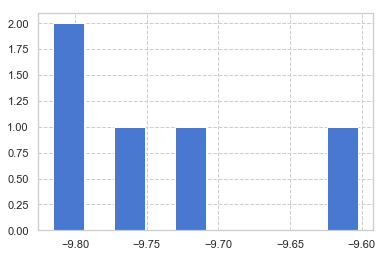

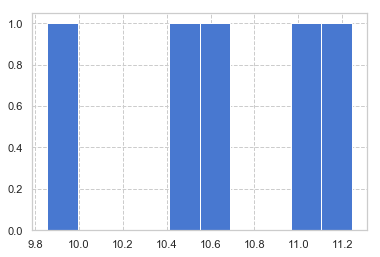

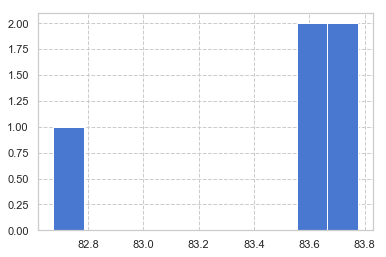

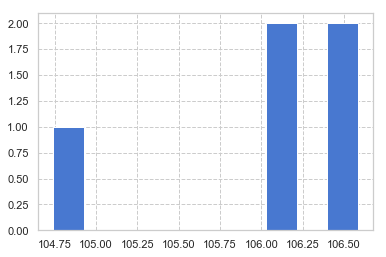

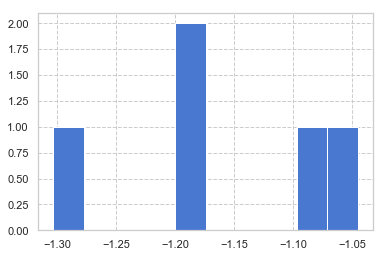

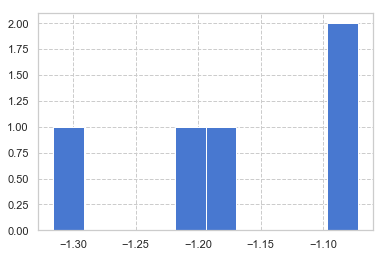

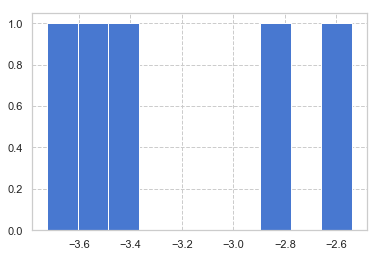

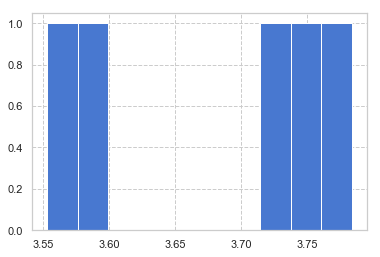

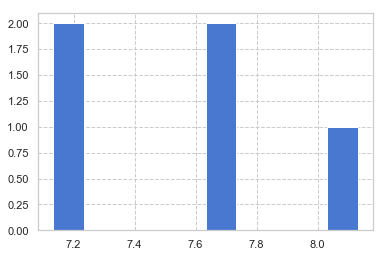

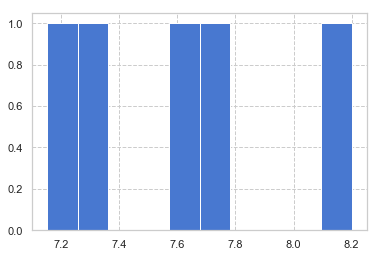

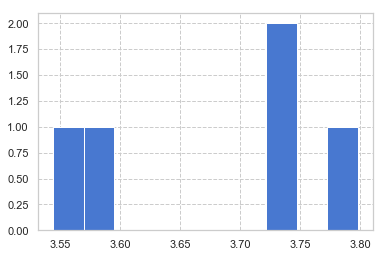

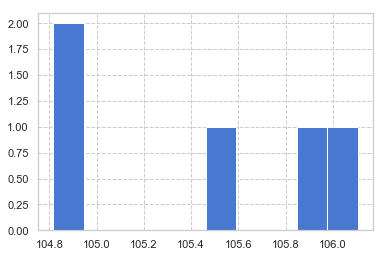

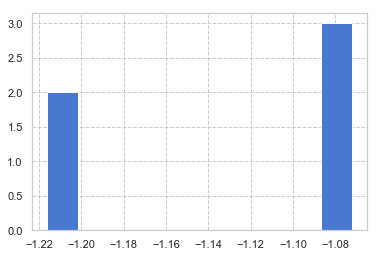

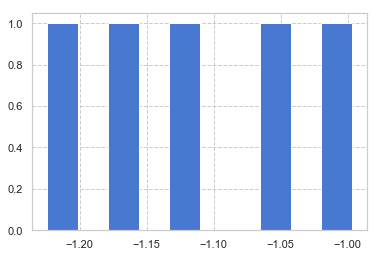

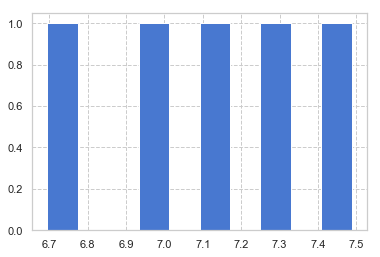

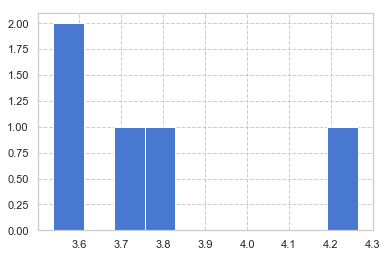

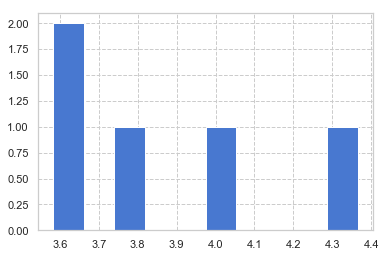

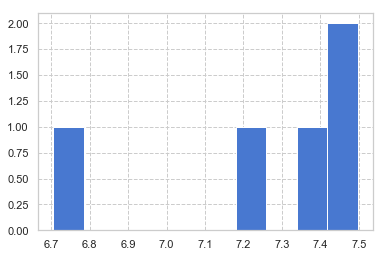

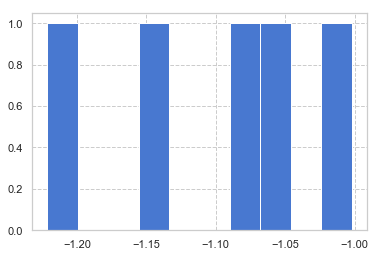

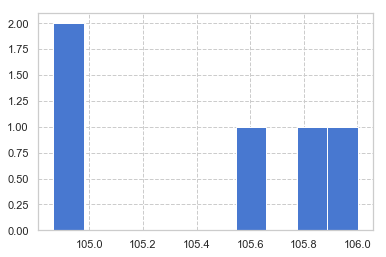

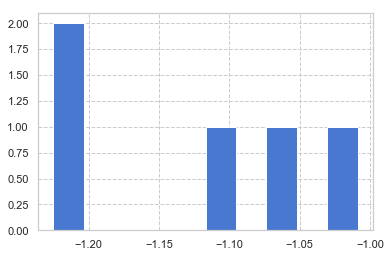

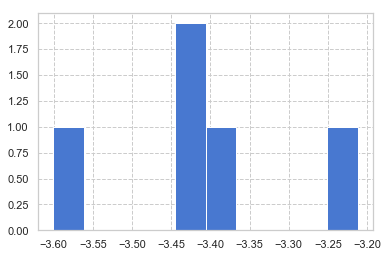

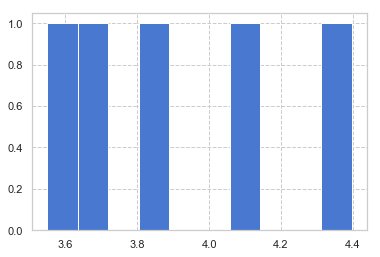

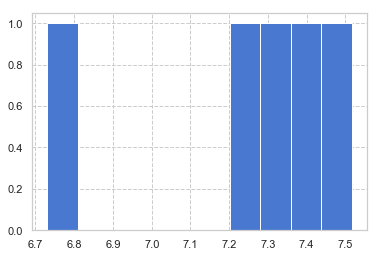

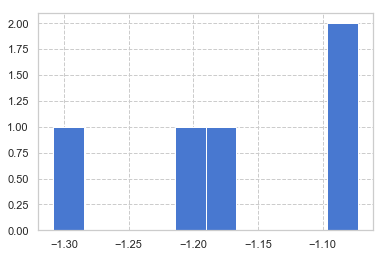

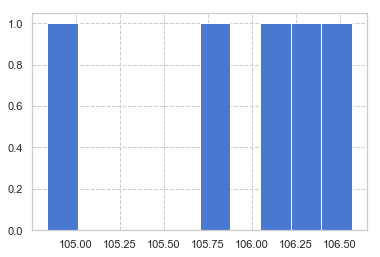

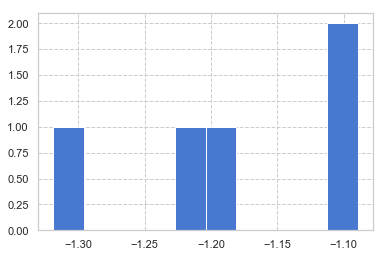

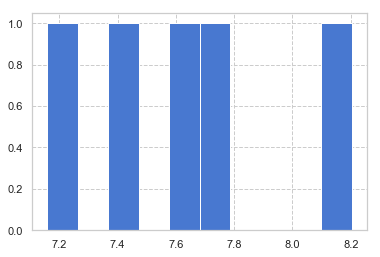

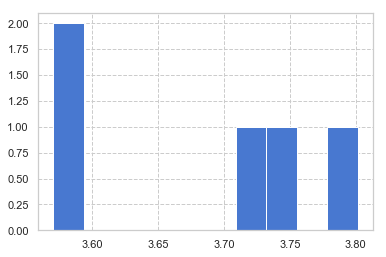

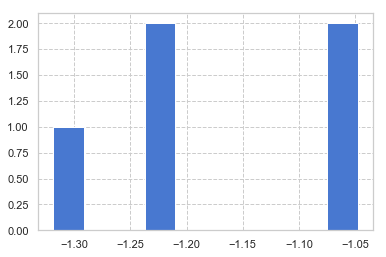

In [36]:
for i, d in submit_list_df.iloc[:, :-1].head(50).iterrows():
    d.hist()
    plt.show()

In [37]:
cor = submit_list_df.iloc[:, :len(sub_files)].corr()
cor 

,submit_gcnn_fold0,submit_gcnn_fold1,submit_gcnn_fold2,submit_gcnn_fold3,submit_gcnn_fold4
submit_gcnn_fold0,1.00000,0.99994,0.99994,0.99994,0.99994
submit_gcnn_fold1,0.99994,1.00000,0.99994,0.99994,0.99994
submit_gcnn_fold2,0.99994,0.99994,1.00000,0.99994,0.99994
submit_gcnn_fold3,0.99994,0.99994,0.99994,1.00000,0.99993
submit_gcnn_fold4,0.99994,0.99994,0.99994,0.99993,1.00000


In [38]:
sampled_id = submit_list_df.sample(frac=0.1).index.values

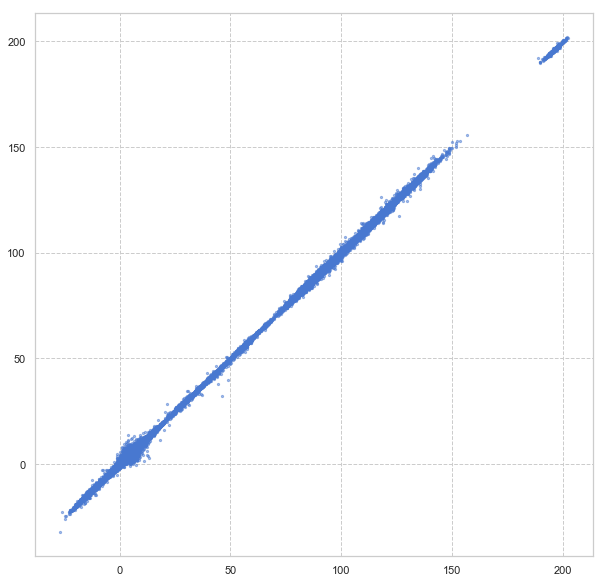

In [39]:
plt.figure(figsize=(10,10))
plt.scatter(x=submit_list_df.iloc[:, 0].loc[sampled_id], 
            y=submit_list_df.iloc[:, 1].loc[sampled_id], alpha=0.5, s= 5)

In [40]:
submit_df = submit_list_df[["mean_score"]]
submit_df.columns = ["scalar_coupling_constant"]

In [41]:
submit_df.head()

,scalar_coupling_constant
id,
4658147,9.12358
4658148,142.90717
4658149,2.30881
4658150,131.82567
4658151,8.57869


,scalar_coupling_constant
id,
4658147,18.89269
4658148,195.58962
4658149,3.45989
4658150,194.32913
4658151,18.99368


,scalar_coupling_constant
id,
4658147,18.86749
4658148,195.61264
4658149,3.35717
4658150,194.32969
4658151,18.99796


In [42]:
Path("../submit/ensemble/gcnn").mkdir(parents=True, exist_ok=True)

In [43]:
sub_file_name = f"../submit/gcnn/004_5fold/submit_gcnn_5fold_blending.csv"
submit_df.to_csv(sub_file_name, index=True)
print(sub_file_name)

../submit/gcnn/004_5fold/submit_gcnn_5fold_blending.csv


In [44]:
!head ../submit/gcnn/004_5fold/submit_gcnn_5fold_blending.csv

id,scalar_coupling_constant
4658147,9.123584747314453
4658148,142.90716552734375
4658149,2.308812141418457
4658150,131.82566833496094
4658151,8.578690528869629
4658152,90.5574951171875
4658153,2.2675204277038574
4658154,-7.717377662658691
4658155,-9.734247207641602


In [27]:
!head ../submit/v003_101/blending_v003_101_20seeds.csv

id,scalar_coupling_constant
4658147,18.582158420376295
4658148,190.3476546988141
4658149,4.103616538933273
4658150,189.55985744588918
4658151,18.222735868668877
4658152,89.95393268550721
4658153,2.3894769642338254
4658154,-7.548801649412429
4658155,-9.624073060330698


In [45]:
ls -l ../submit/gcnn/004_5fold/

total 787048
drwxr-xr-x  7 kenichi.matsui  1522739515       224  8 25 19:45 original/
-rw-r--r--  1 kenichi.matsui  1522739515  67029259  8 25 19:46 submit_gcnn_5fold_blending.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67114441  8 25 19:29 submit_gcnn_fold0.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67114331  8 25 19:33 submit_gcnn_fold1.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67115912  8 25 19:43 submit_gcnn_fold2.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67110310  8 25 19:43 submit_gcnn_fold3.csv
-rw-r--r--@ 1 kenichi.matsui  1522739515  67109002  8 25 19:44 submit_gcnn_fold4.csv


In [46]:
# !kaggle competitions submit -c champs-scalar-coupling -f ../submit/gcnn/004_5fold/submit_gcnn_5fold_blending.csv -m "gcnn 5 fold ensemble CV:-1.542"

100%|██████████████████████████████████████| 63.9M/63.9M [00:22<00:00, 3.00MB/s]
Successfully submitted to Predicting Molecular Properties

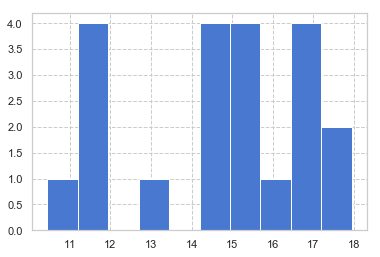

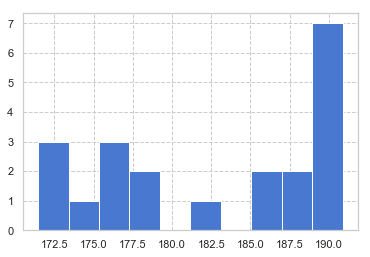

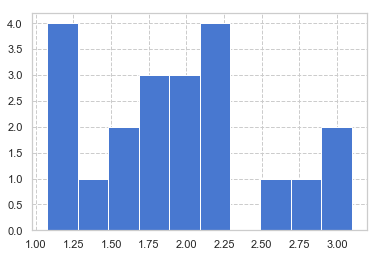

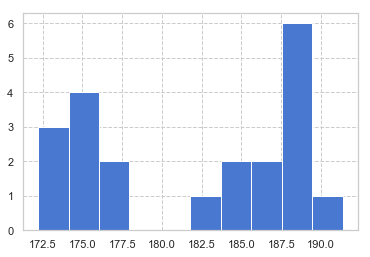

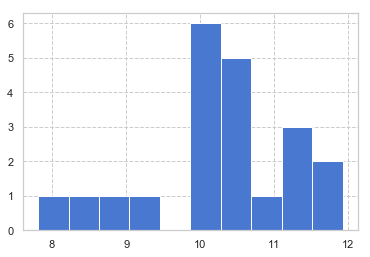

In [33]:
for i, d in submit_list_df.head().iterrows():
    d.hist()
    plt.show()

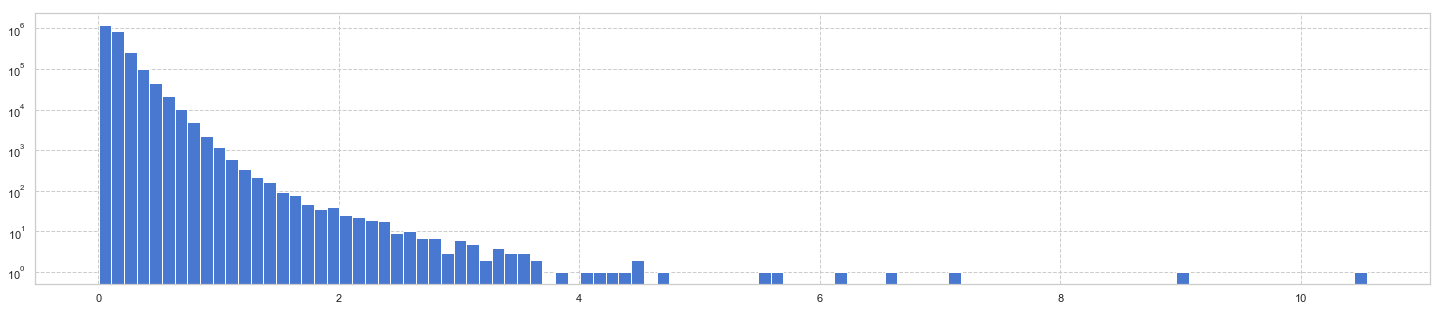

In [59]:

plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_std.hist(ax=ax, bins=100)
plt.yscale("log")

In [38]:
cv_std = submit_list_df.std(axis=1)
cv_mean = submit_list_df.mean(axis=1)
cv_value = cv_std/cv_mean

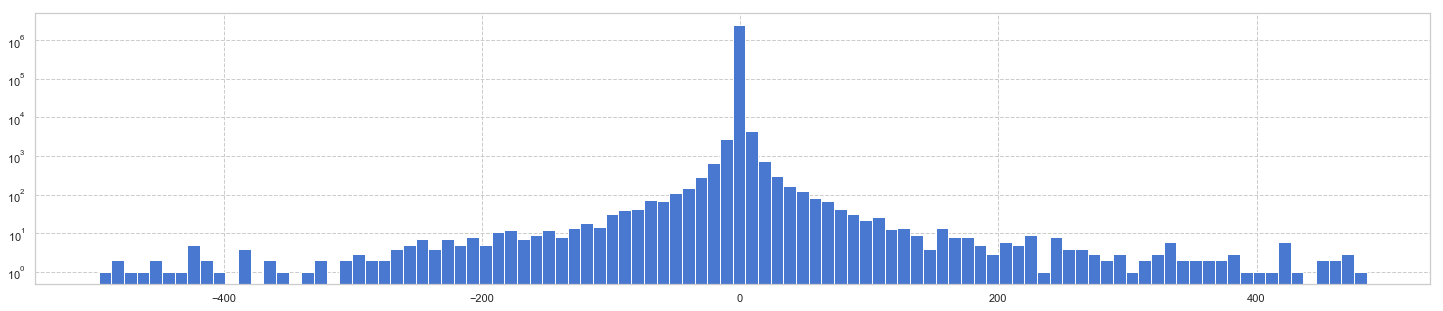

In [51]:
plt.figure(figsize=(25,5))
ax = plt.subplot(111)
cv_value[np.abs(cv_value) < 500].hist(ax=ax, bins=100)
plt.yscale("log")

In [47]:
np.abs(cv_value).sort_values(ascending=False)[:10]

id
5412746   219,716.34590
5465807   126,850.04206
5546431    85,100.91446
6552445    60,056.74870
5436786    18,762.42936
6942259    16,531.30469
4989294    13,911.01801
6462400    10,928.18863
4993772    10,377.60660
6114912     9,173.00372
dtype: float64

In [53]:
high_cv = cv_value[np.abs(cv_value) > 500]
high_cv

id
4698369     -6,946.80593
4710913        784.91746
4823283        918.63092
4825478      3,784.50219
4853540        576.83325
4882092       -623.90341
4892956      2,308.43802
4902768     -3,048.53894
4921967        633.81338
4935801        901.29538
4989294    -13,911.01801
4993772     10,377.60660
5085605     -2,476.27122
5098336        810.44443
5124395       -829.80919
5156635        595.45082
5169103     -6,183.53375
5181557      1,101.13801
5212243     -6,319.13448
5219726        734.34349
5241459      1,389.43887
5247798     -1,082.86622
5254630        556.98296
5263450        949.86269
5264679     -3,482.49522
5267715     -1,060.28821
5272631      1,867.69635
5307174      1,155.11992
5308095      4,925.84640
5335302      1,355.83248
5338066      2,875.03888
5397576      1,180.83817
5398959     -1,424.92753
5403209       -877.26486
5412746   -219,716.34590
5415657     -1,024.71457
5435504     -1,063.17269
5436786     18,762.42936
5465807   -126,850.04206
5467389     -1,476.073

In [55]:
submit_list_df_ = submit_list_df.copy()

In [56]:
submit_list_df_["std_score"] = submit_list_df_.std(axis=1)

In [58]:
submit_list_df_.loc[high_cv.index]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4698369,-0.10891,0.20726,-0.19428,0.14164,0.10174,-0.10369,-0.11895,0.00188,-0.05684,-0.28368,0.19707,-0.10099,-0.11010,-0.20905,0.25207,0.25043,0.08866,0.02276,-0.20298,0.22548,-0.00002,0.16780
4710913,0.05207,0.08899,-0.15923,0.00470,-0.07532,-0.03570,-0.04131,-0.06193,-0.11053,-0.01497,0.12922,0.03613,0.09471,0.02362,0.05518,-0.02941,0.08073,-0.01844,0.06022,-0.07685,0.00009,0.07374
4823283,-0.11116,0.22432,-0.37545,0.60204,-0.13754,0.06240,0.20810,0.40585,-0.18211,0.04688,-0.19219,0.23043,-0.09052,0.17002,-0.45115,0.11842,0.21245,-0.58632,0.06607,-0.21436,0.00031,0.28427
4825478,-0.12516,0.18095,-0.14940,0.07228,0.02214,0.24390,-0.01154,-0.02196,-0.04942,-0.17620,-0.01985,-0.02738,0.14320,-0.24234,-0.01120,0.14124,-0.14500,0.06739,0.10497,0.00403,0.00003,0.12391
4853540,-0.15255,0.10124,-0.04742,-0.17721,0.16389,0.07497,0.10726,0.00017,-0.00006,0.29439,0.11748,0.14192,-0.06900,-0.02649,0.08587,-0.02954,0.00904,-0.21160,-0.26380,-0.11382,0.00024,0.13654
4882092,-0.06139,0.10911,-0.07718,-0.01266,-0.01576,0.05420,0.04878,0.04608,-0.06544,-0.01899,0.07845,-0.04549,-0.08414,0.01805,0.08898,0.01646,0.03799,0.01525,-0.02814,-0.10609,-0.00010,0.05986
4892956,0.13003,-0.04687,-0.26013,-0.14713,-0.15578,0.06756,-0.07169,0.21287,-0.07898,-0.16460,0.20092,0.13675,-0.02912,0.21120,0.01110,0.00870,-0.04994,0.03103,0.11166,-0.11639,0.00006,0.13327
4902768,-0.02569,-0.00599,0.01376,0.08220,0.12647,-0.11451,-0.00514,0.02718,-0.06584,-0.06934,0.02045,-0.06207,0.00658,0.05293,-0.03427,0.02239,0.01581,-0.07608,0.03884,0.05194,-0.00002,0.05731
4921967,-0.03500,-0.04545,-0.04124,0.03967,-0.00208,-0.05063,-0.07278,0.05059,0.05512,-0.05801,0.02634,-0.00415,-0.00704,0.07495,0.09477,0.01673,-0.01851,-0.05953,0.00821,0.02950,0.00007,0.04683


In [66]:
(cv_std>2).sum()

164

In [67]:
submit_list_df_[cv_std>2]

,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,scalar_coupling_constant,mean_score,std_score
id,,,,,,,,,,,,,,,,,,,,,,
4658147,14.42941,17.94441,17.13644,15.27704,15.10848,11.30809,16.10830,10.45234,17.09311,15.45748,14.73881,17.00781,17.35652,15.09924,14.48620,11.58494,16.53874,11.38786,11.89966,13.16861,14.67917,2.25488
4658148,185.88040,189.22815,177.96684,178.29521,189.48546,172.57653,185.81137,172.15734,187.75813,190.59805,176.24125,176.60991,189.97100,173.97079,189.41381,171.46370,176.38060,188.38959,189.59037,190.87225,182.63304,7.13280
4658150,185.21704,187.47601,177.79644,177.43159,187.79254,172.67824,185.47784,173.02363,186.61189,189.29749,175.51608,175.60289,188.88495,174.97048,188.24557,172.21388,175.36830,187.60289,188.22205,191.36174,182.03958,6.64369
4659320,33.08035,34.81430,26.73043,29.23484,27.54208,28.06737,28.00276,27.18509,28.28530,35.14333,26.87740,35.11687,28.20407,29.13082,27.81241,28.90023,27.67827,34.55264,27.81805,28.13963,29.61581,2.93531
4694991,132.74731,133.13240,133.94892,135.31686,131.07832,136.20143,133.15464,135.87478,134.11250,132.65901,138.71237,133.24406,135.62201,134.15559,132.68408,136.46895,135.20510,137.84316,132.81744,137.74618,134.63626,2.00375
4715174,141.75089,142.87002,147.99925,141.82936,147.58080,142.10264,146.31433,146.20726,141.97111,144.89666,146.48847,142.02606,141.62871,145.00860,142.72833,141.24091,144.34427,142.44431,143.81411,144.59190,143.89190,2.08879
4762582,34.66631,34.38711,39.29155,38.80190,38.87811,39.45968,38.91209,38.50681,33.65596,36.36730,38.52476,35.62383,35.08928,34.22979,39.19195,41.92236,38.23331,38.20737,38.30802,41.18223,37.67199,2.29767
4788766,132.34788,135.45968,133.93357,138.07553,130.82078,137.22836,132.82423,135.02552,134.61903,131.62559,139.94568,134.68519,134.67938,134.64871,133.76503,135.73918,133.26268,138.07366,134.19426,135.93369,134.84438,2.20111
4810197,29.24068,27.94773,27.78779,28.08638,27.99354,27.88377,32.53005,32.81597,31.96069,33.26076,27.82990,33.90253,32.63323,33.19148,27.69970,28.37092,28.09255,30.11552,28.61115,28.79332,29.93738,2.26515
